<strong>Project Report: Group 30A -- Tonmoy T. Bhattacharya</strong>
<strong>Project Title: A Grover Search-based Algorithm for the List Coloring Problem</strong>

<i><u>Notes of Project Contents and Report Structure:</u></i>
1. This Project follows the Research-paper with the same title as this report, by Sayan Mukherjee.
2. The paper however has no qiskit code or even a complete implementation-oriented circuit schematic to follow.
3. The first, core task of this project is to develop the Qiskit code -- which has been done from scratch. all of the code is original for this project and has not been developed from any previous code base. Additionally, a technique to augment the performance of the algorithm is also proposed.
4. The code seeks to develop patterns to develop generalizability, the ultimate objective is for the user to simply enter a comma-separated-file with the adjacency matrix as input and receive the colored-graph as output.
5. This task is done with the only remaining task being that of generalizing an algorithm to auto-generate the Oracle gate for graphs of any dimension.
6. Furthermore, a technique is proposed to reduce the search-space for the oracle so as to increase the efficiency of the overall algorithm.

Therefore, this project consists of coding (from scratch) the algorithm proposed by the paper of Mukherjee, and also proposing an additional technique to the algorithm itself. This repost is based on the jupyter notebook with thoroughly documented code, circuit diagrams and proper analysis. That is so as this is the clearer than writing a volume of text to describe the code. The PPT that goes along with this report will have a section on using networkx to draw the graph - these are omitted here to avoid the report being too long. 
Finally, a new technique is presented at the end of the report to augment the performance of the algorithm proposed by Mukherjee. 
<b>PLEASE NOTE: The report has an appendix which can be avoided, it simply h details like qiskit version, and figures from the paper of Mukherjee that may be referenced if desired but is not necessary to be read.</b>

Analysis of Paper, with focus on the task to be solved: 
1. The paper of Mukherjee proposes the use of Grover's search to solve the graph coloring problem with modifications to the initialization phase (to reduce the supersposition to only have states representative of the colors of the vertices in the graph.
2. Thereafter, in modification to the diffusion operator of the classical Grover's algorithm by reflecting about the initialization-oracle gates with a phase flip ancilla to negate selected states.

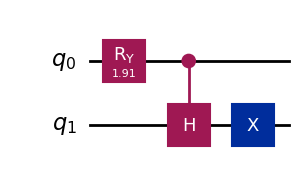

In [19]:
'''
A 3-Vertex, 3-edge case as discussed in the source paper if first developed here.
The algorithm requires that every pair of qubits representing a vertex,
be initialized with E3 gate that puts those qubits into selective superposition
'''
#make gate E3 -> Ry(2*asin(np.sqrt(2)/np.sqrt(3)))

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister

def Ry_for_E3_Gate(θ = 2 * np.arcsin(np.sqrt(2)/np.sqrt(3))):
    import numpy as np
    from qiskit import QuantumCircuit
    circuit = QuantumCircuit(1, name='RyGate_for_E3_Gate')
    circuit.ry(θ, 0)
    circuit.to_gate()
    return circuit
    
def E3_Gate_noCBits():
    import numpy as np
    from qiskit import QuantumCircuit
    circuit = QuantumCircuit(2, name='E3_Gate')
    circuit = circuit.compose(Ry_for_E3_Gate(), 0)
    circuit.ch(0,1)
    circuit.x(1)
    circuit.to_gate()
    return circuit

#inverse of the above gate is needed towards the end of the circuit, that is coded below:
def E3_Inverse_Gate_noCBits():
    E3_inv = E3_Gate_noCBits().inverse()
    return E3_inv

E3_Gate_noCBits().draw(output='mpl')

In [2]:
#Testing the  code to confirm that it produces the desired code:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer 
from qiskit import transpile
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi

qc = E3_Gate_noCBits()
stv1 = qi.Statevector.from_instruction(qc)
stv1.draw('latex', prefix='Statevector Of E3 Gate:')

<IPython.core.display.Latex object>

<b>Code to solve the 3-Vertex, 3-Edge graph follows</b>

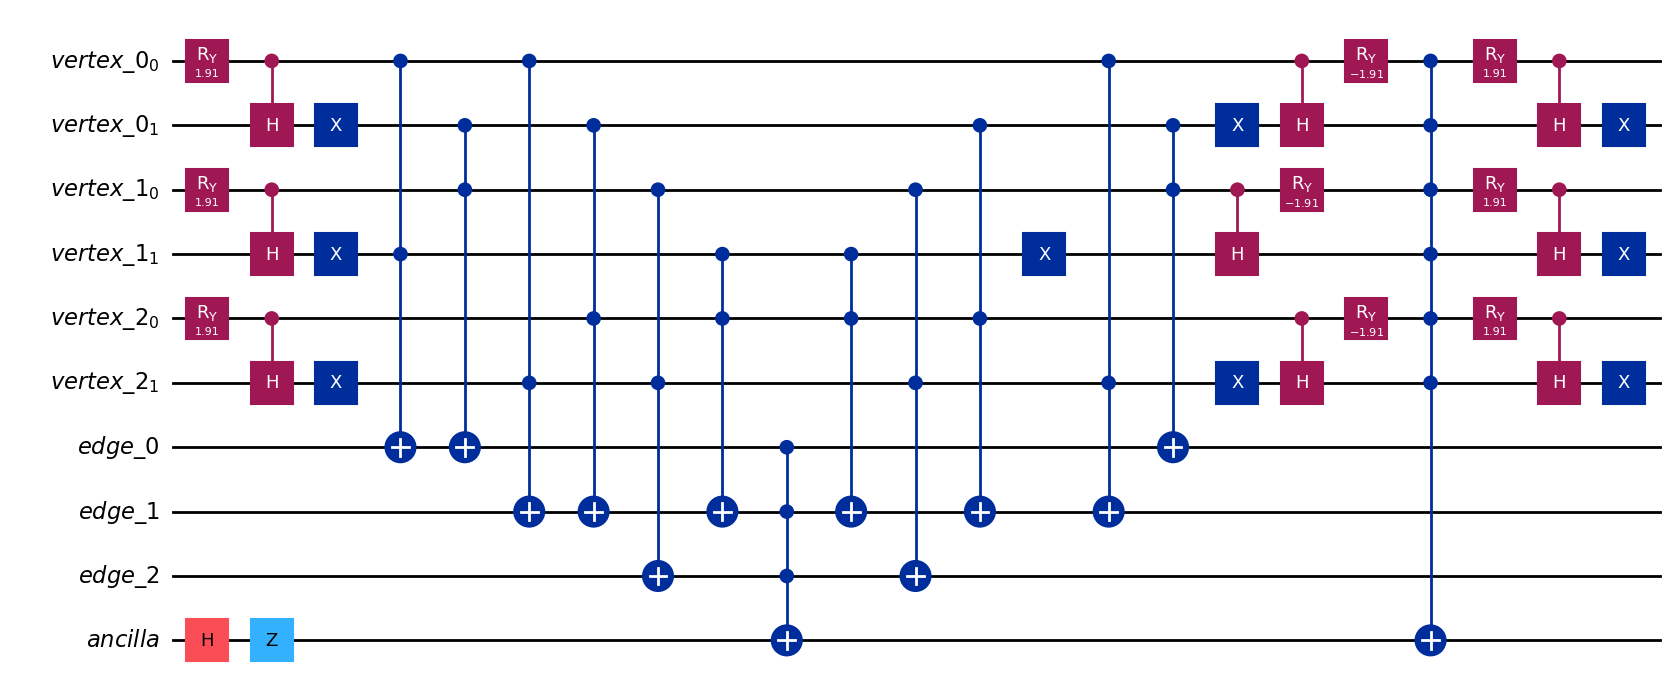

In [15]:
#make circuit for 3-vertex, 3-edge case

#num of qubits = 2 * Num of Vertices + Num of edges + 1 for the phase-flip ancilla
num_vertices = 3
num_edges = 3
num_ancilla = 1
num_qubits = 2*num_vertices + num_edges + num_ancilla

#make a list of QuantumRegisters representing vertices
list_qr_vertices = []
for i in range(num_vertices):
    name = 'vertex_'+str(i)
    list_qr_vertices.append(QuantumRegister(2, name))
#make a list of QuantumRegisters representing edges
list_qr_edges = []
for i in range(num_edges):
    name = 'edge_'+str(i)
    list_qr_edges.append(QuantumRegister(1, name))
#this QuantumCircuit object will hold the circuit that is incrfementally developed, the steps are documented with the code below:
#Note: the code avoids hard-coding as a core design principle.
qc_3v_3e = QuantumCircuit(*list_qr_vertices, *list_qr_edges, QuantumRegister(1, name='ancilla'), name='full_circuit_2v_1e')
#attach E3 Gate to all vertices
def add_E3_all_vertices(circ, num_vertices):
    c = None
    for i in range(num_vertices):
        f = i*2
        circ = circ.compose(E3_Gate_noCBits(), qubits=[f,f+1])
    return circ
def add_E3Inv_all_vertices(circ, num_vertices):
    for i in range(num_vertices):
        f = i*2
        circ = circ.compose(E3_Inverse_Gate_noCBits(), qubits=[f,f+1])
    return circ
qc_3v_3e = add_E3_all_vertices(qc_3v_3e, len(list_qr_vertices))
#add H and Z gates to the ancilla qubit (which is always the last qubit in the QuantumCircuit object
num_qubits_circ = len(qc_3v_3e.qubits)
qc_3v_3e.h(num_qubits_circ-1)
qc_3v_3e.z(num_qubits_circ-1)
#The connections internal to the Oracle is set out as a list of tuple
#A future task for this project will be to develop an algorithm to automatically develop such a list
#but even in that case there will be no changes to the code here, only the list of tuples like below will be auto-generated.
connection_tuples = [(0,3,6), (1,2,6), (0,5,7), (1,4,7), (2,5,8), (3,4,7)]
#attach ccx gates - straight order
for i in range(len(connection_tuples)):
    qc_3v_3e.ccx(connection_tuples[i][0], connection_tuples[i][1], connection_tuples[i][2])
#attach phase-kickback --> all edge qubits in control, ancilla as target
#ancilla - last qubit, controls - |e| qubits below that
controls = []
for i in range(num_edges):
    controls.append((num_qubits_circ-1) - (i+1))
qc_3v_3e.mcx(controls, num_qubits_circ-1)
#attach ccx gates - reverse order
for i in range(len(connection_tuples)-1, 0, -1):
    qc_3v_3e.ccx(connection_tuples[i][0], connection_tuples[i][1], connection_tuples[i][2])

#attach E3_Inverse Gates to all vertices
qc_3v_3e = add_E3Inv_all_vertices(qc_3v_3e, len(list_qr_vertices))

#attach mcx with all vertex-qubits in (open) control and the traget set for the ancilla qubit
from qiskit.circuit.library import MCXGate
controls_ = list(range(2*num_vertices)) + [num_qubits-1]
qc_3v_3e.append(MCXGate(2*num_vertices, ctrl_state="1"*2*num_vertices), controls_)

#add the last layer of E3 gates to the circuit
qc_3v_3e = add_E3_all_vertices(qc_3v_3e, len(list_qr_vertices))

#display the circuit developed
qc_3v_3e.draw(output='mpl')

<b>The circuit generated above will be tested and <u>results</u> analysed below...</b>

In [16]:
#measure qubits
qc_3v_3e.measure_all()
backend = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc_3v_3e, backend)
job = backend.run(new_circuit)
results = job.result()#.get_counts()
counts = results.get_counts()
#print(counts)
from qiskit.visualization import plot_histogram

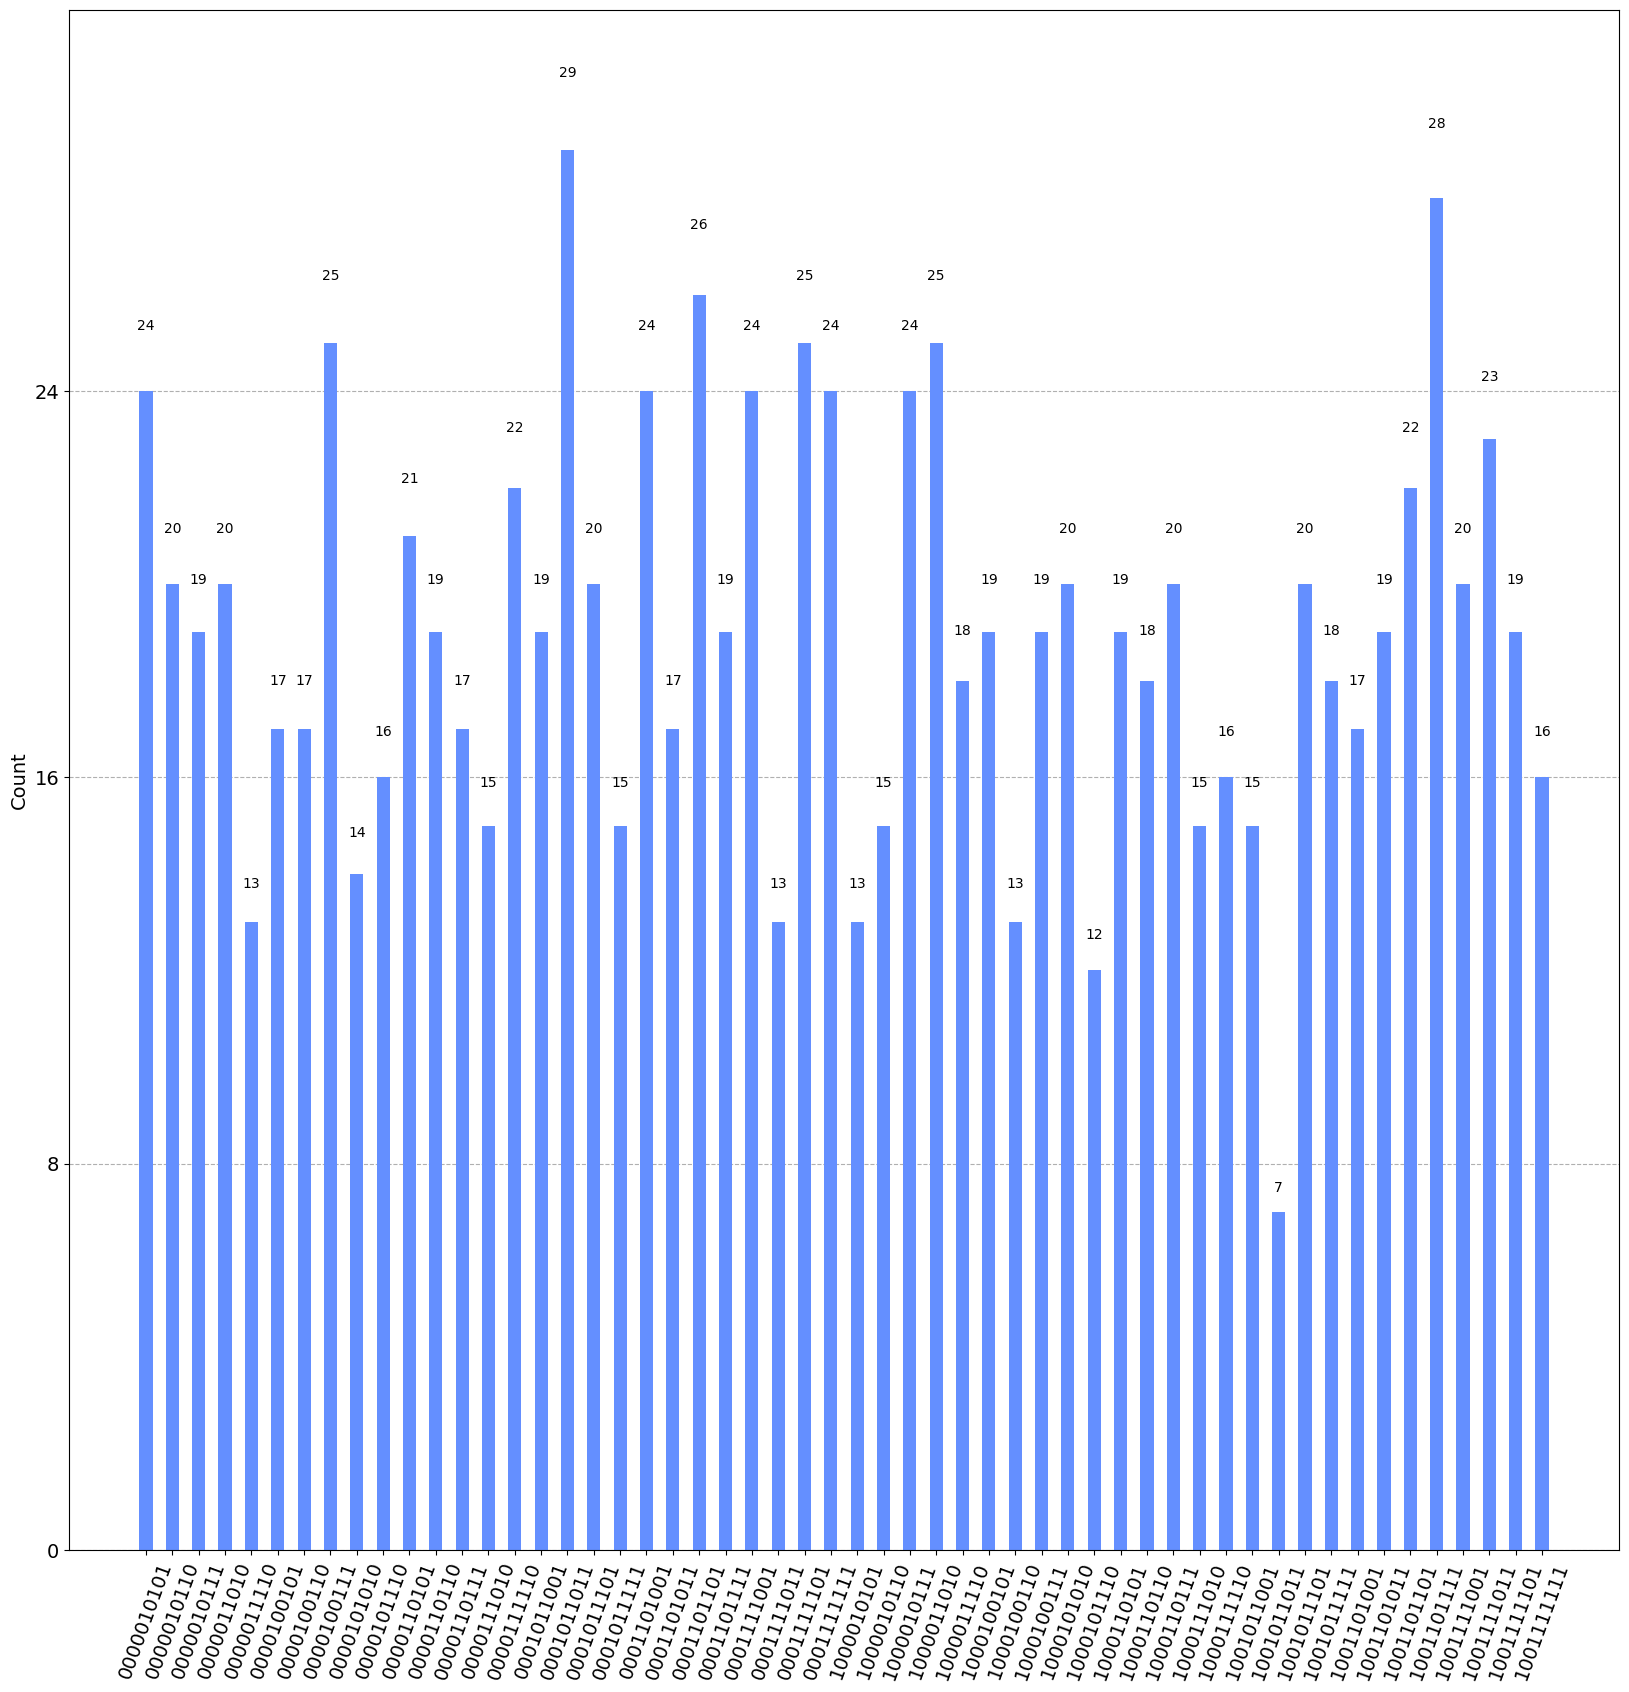

In [17]:
plot_histogram(counts, figsize=(20,20))

In [18]:
ccopy =counts.copy() #make a copy of the results to avoid malforming data during further processing
num_top_items = 3
top_states = sorted(ccopy, key=ccopy.get, reverse=True)[:num_top_items] #get 3 top states
print(f'The top {len(top_states)} states are in the form {top_states}.')

'''since Qiskit follows little-endianness, the each pair of least-significant bits in the bit string state the colors'''
#extract the 3 colors for each of the vertices per state
list_colors = []
len_state_string = len(top_states)
for i in range(len_state_string):
    list_colors.append((top_states[i][8:],top_states[i][6:8:],top_states[i][4:6]))
print(f'The colors for each vertex in the above list are: {list_colors}.')

#since this is a probabilistic algorithm and we are not running a lot of repetitions of the diffusion operator,
#we will get the most repeated item as the chosen answer
import statistics
ans = statistics.mode(list_colors)
print(f'The proposed coloring is: {ans}.')

The top 3 states are in the form ['0001011011', '1001101111', '0001101101'].
The colors for each vertex in the above list are: [('11', '10', '01'), ('11', '11', '10'), ('01', '11', '10')].
The proposed coloring is: ('11', '10', '01').


<b><u> RESULT:</u><i>The above generates the correct graph-coloring by getting the most frequently given output among the top 3 answers. This is due to the probabilistic nature of the algorithm used. A greater number of repetitions of the circuit would have increaded the probability of getting the right answer in one go but at the cost of greater circuit elements. This option therfore is used as a compromise here. However, a number of repetiions to the circuit woul dyield a more stable trend of reliable answers.</i></b>

<u>Proposal for addition to the Algorithm</u>: It is proposed that further reduction in the statespace be made by assigning any color to one of the nodes and also any color to any unconnected, free-floating nodes. 
<p></p>
Further Work:

1. Develop an algorithm to automatically generate the connections in the Oracle.<br>
2. Implement and test the above mentional proposal for addition to the algorithm in the original paper.

Sources:

[1] A Grover Search-based Algorithm for the List Coloring Problem, Sayan Mukherjee, Digital Object Identifier 10.1109/TQE.2020.DOI<br>
[2] Coloring graphs using Grover search: Part 1, Sayan Mukherjee, https://blueqat.com/Sayan%20M./3b90bf72-ad93-41c1-9930-b27d2d204709
